In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv("D:/Data Analysis/Files/export.csv")

In [3]:
print("Total reported days:", len(df))

Total reported days: 1828


In [4]:
# I want to drop columns which are empty
df.drop(columns=['snow', 'wdir', 'snow', 'wdir', 'wpgt', 'tsun'], inplace=True) # Manually dropping empty columns
df.dropna(how='all', inplace=True, axis=1)  # Alternative way to drop empty columns
cleaned_columns = df.columns.tolist()
print("Columns after cleaning:", cleaned_columns)

Columns after cleaning: ['date', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']


In [5]:
# Filling NaNs with 0
df['prcp'] = df['prcp'].fillna(0)
df = df[df['prcp'] < 40]
print(len(df))

1827


In [6]:
fake_rows = df[
    (df['tavg'] == df['tmax']) |
    (df['tmax'] == df['tmin']) |
    (df['prcp'] > 50.0)
]
print("Number of fake rows detected:", len(fake_rows))

Number of fake rows detected: 0


In [7]:
df["date"] = pd.to_datetime(df["date"])

In [8]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year 

In [9]:
# Now lets exclude data for 2025 
df = df[df["year"] < 2025]

In [10]:
hottest_date = df.groupby('date')['tmax'].max().sort_values(ascending=False)
coldest_date = df.groupby('date')['tmin'].min().sort_values(ascending=True)

In [11]:
hottest_day = df[df['tmax'] == df['tmax'].max()]
coldest_day = df[df['tmin'] == df['tmin'].min()]

Precipitation Data

In [12]:
# Now lets analyze total counts rains per year
prcp_days = df[df["prcp"] > 0.5].groupby("year")["prcp"].count()

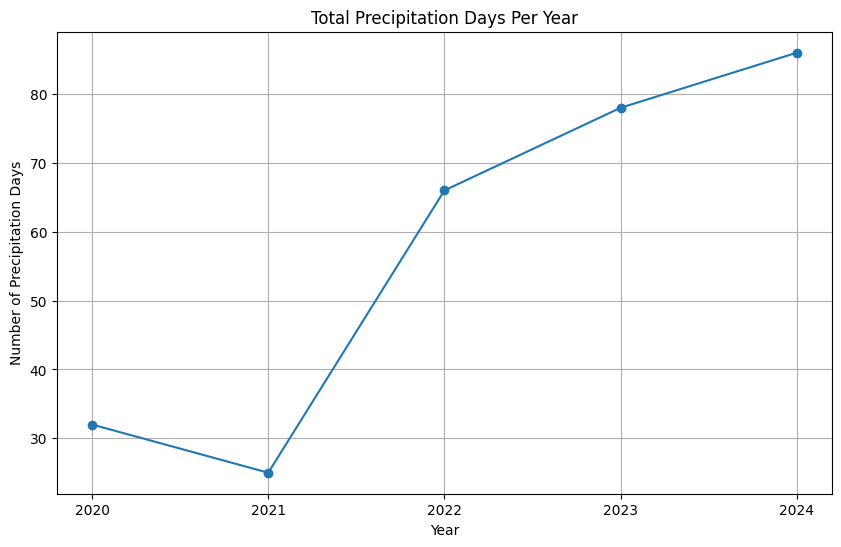

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prcp_days.index, prcp_days.values, marker='o')
ax.set_title("Total Precipitation Days Per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Precipitation Days")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.grid()
plt.show()

In [14]:
snowy_per_year = df[(df["tavg"] < 3) & (df["prcp"] > 0.5)].groupby("year")["prcp"].count()

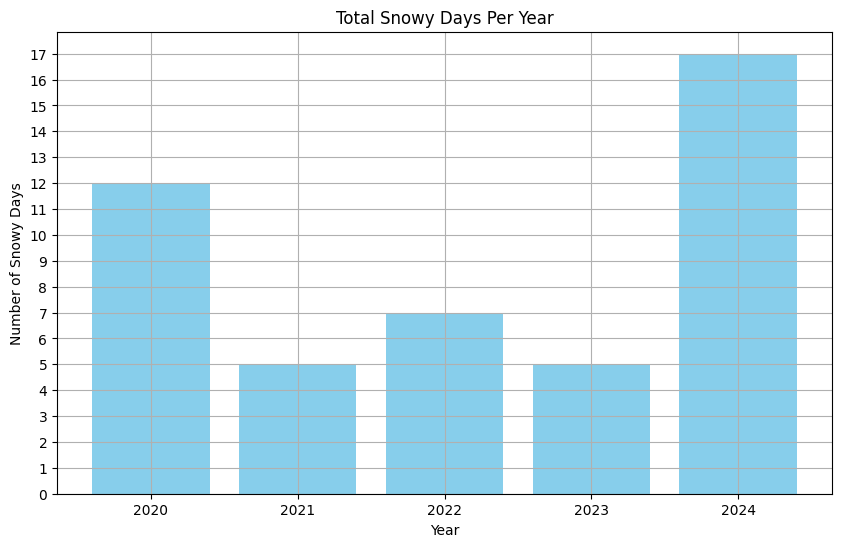

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(snowy_per_year.index, snowy_per_year.values, color='skyblue')
ax.set_title("Total Snowy Days Per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Snowy Days")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.grid()
plt.show()


Visualizing the Rain

In [16]:
df['date'] = pd.to_datetime(df['date'])
rainy_days = df[(df['prcp'] > 0.5) & (df['tavg'] > 3)][['date', 'prcp']].copy() # we take where it rained and temp > 3C to deminish snow effect

In [17]:
# Preparing data for plotting
# We set everything to year 2000 so 29 Feb works fine
rainy_days['plot_date'] = rainy_days['date'].apply(lambda d: d.replace(year=2000))
# Extract the real year so we can group by it later
rainy_days['real_year'] = rainy_days['date'].dt.year

--- TEST 1: Separate ---


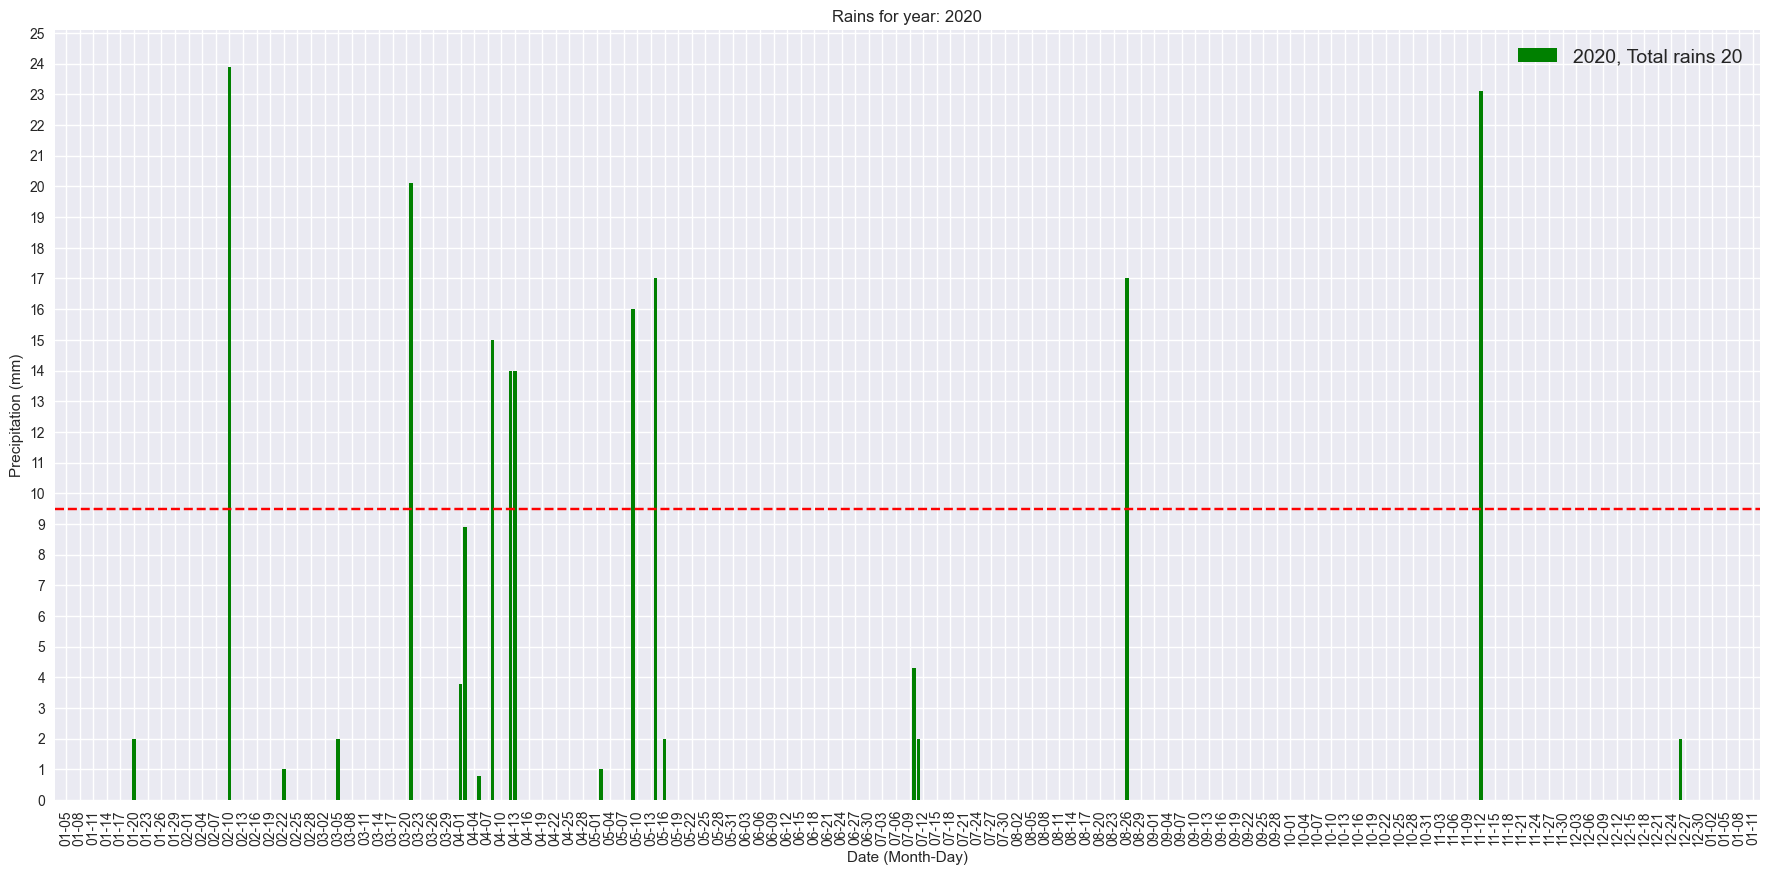

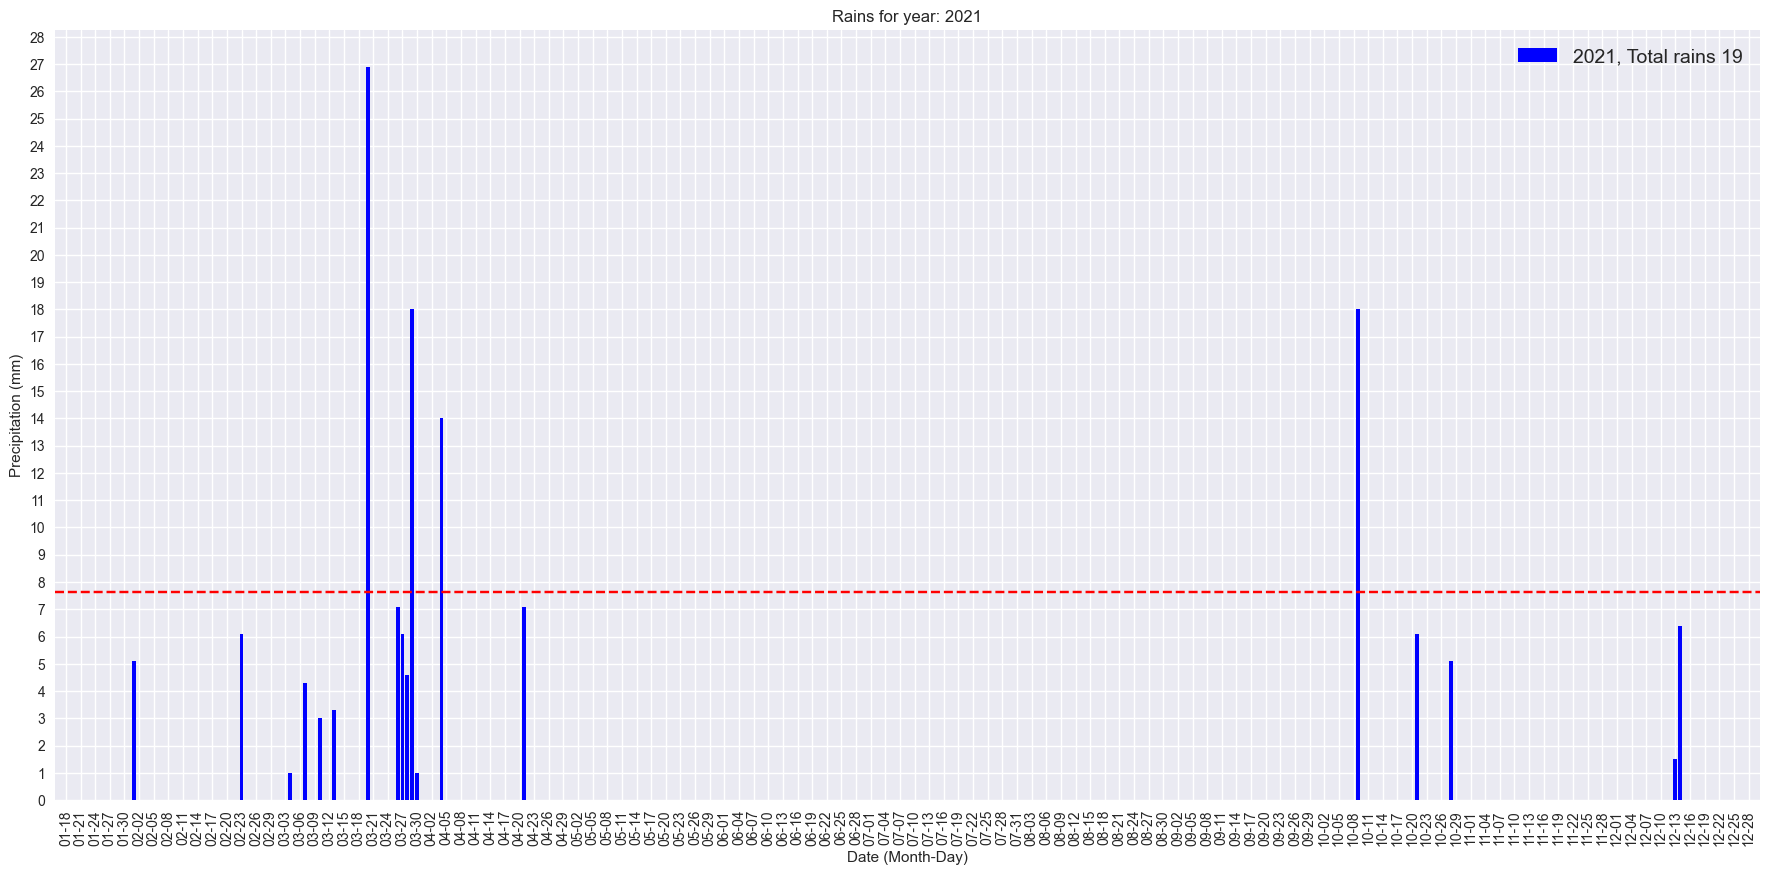


--- TEST 2: Together ---


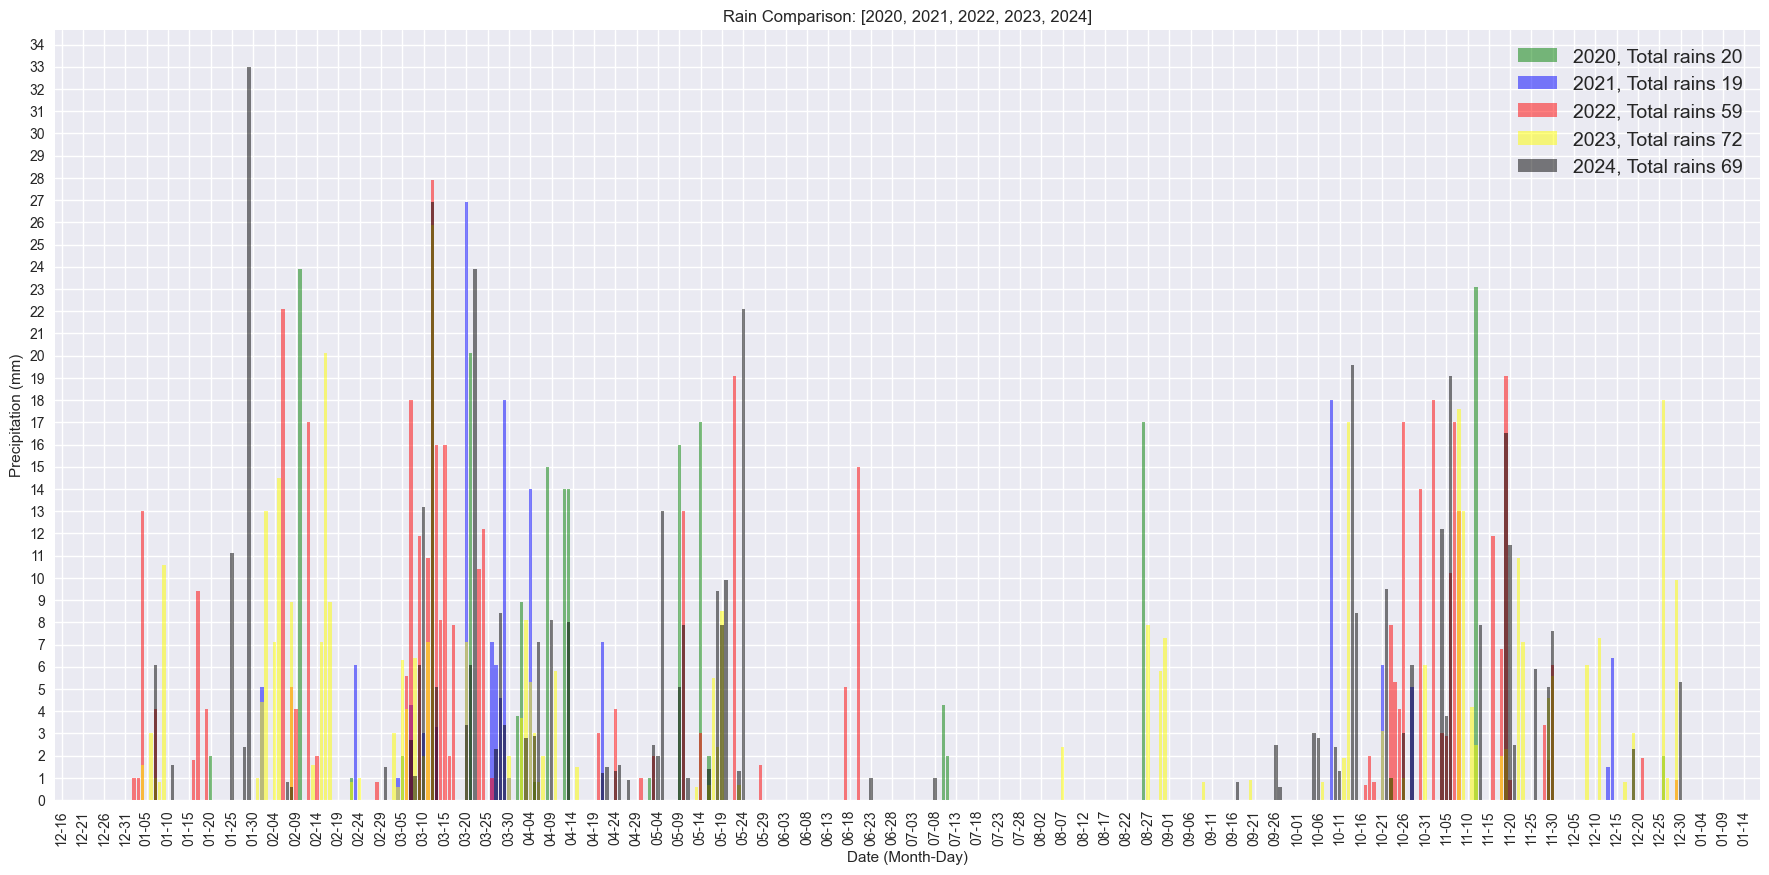

In [ ]:
def analyze_rain_year(years, together=False): # Changed default to False for clarity
    """
    Analyze and plot rain data.
    If together=True, overlays all years on one chart.
    If together=False, makes separate charts.
    """
    plt.style.use("seaborn-v0_8")
    colors = {2020: 'green', 2021: "blue", 2022: "red", 2023: "yellow", 2024: "black"}
    available_years = rainy_days['real_year'].unique()

    if not together: 
        for year in years:
            if year not in available_years:
                print(f"Year {year} skipped (No Data)")
                continue
            
            # CREATE CANVAS INSIDE THE LOOP
            fig, ax = plt.subplots(figsize=(22, 10))
            
            subset = rainy_days[rainy_days['real_year'] == year]
            
            ax.bar(subset['plot_date'], subset['prcp'],
                   color=colors.get(year, "grey"),
                   label=f"{year}, Total rains {len(subset)}")
            
            # Format THIS specific chart
            ax.set_title(f"Rains for year: {year}")
            ax.set_xlabel("Date (Month-Day)")
            ax.set_ylabel("Precipitation (mm)")
            ax.legend(loc='upper right', fontsize=14)
            ax.axhline(y=subset['prcp'].mean(), color='red', linestyle='--', label="Avg Rain")

            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
            plt.xticks(rotation=90, size=10)
            plt.grid(True)
            
            plt.show()

    else:
        fig, ax = plt.subplots(figsize=(22, 10))
        
        for year in years:
            if year not in available_years:
                continue
            
            subset = rainy_days[rainy_days['real_year'] == year]

            ax.bar(subset['plot_date'], subset['prcp'],
                   color=colors.get(year, "grey"),
                   label=f"{year}, Total rains {len(subset)}",
                   alpha=0.5)

        ax.set_title(f"Rain Comparison: {years}")
        ax.set_xlabel("Date (Month-Day)")
        ax.set_ylabel("Precipitation (mm)")
        ax.legend(loc='upper right', fontsize=14)
        
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.xticks(rotation=90, size=10)
        plt.grid(True)
        
        plt.show()

print("--- TEST 1: Separate ---")
analyze_rain_year([2020, 2021], together=False)

print("\n--- TEST 2: Together ---")
analyze_rain_year([2020, 2021, 2022, 2023, 2024], together=True)

# Wind Visualization

Do we get steady windflow despite of the seasons?

In [19]:
df['wspd'] = df['wspd'].fillna(0)
# Create the "Fake Date" for overlaying years (Setting everything to Year 2000)
df['plot_date'] = df['date'].apply(lambda d: d.replace(year=2000))
# Extract real year for the loop
df['real_year'] = df['date'].dt.year

In different Canvas in daily basis

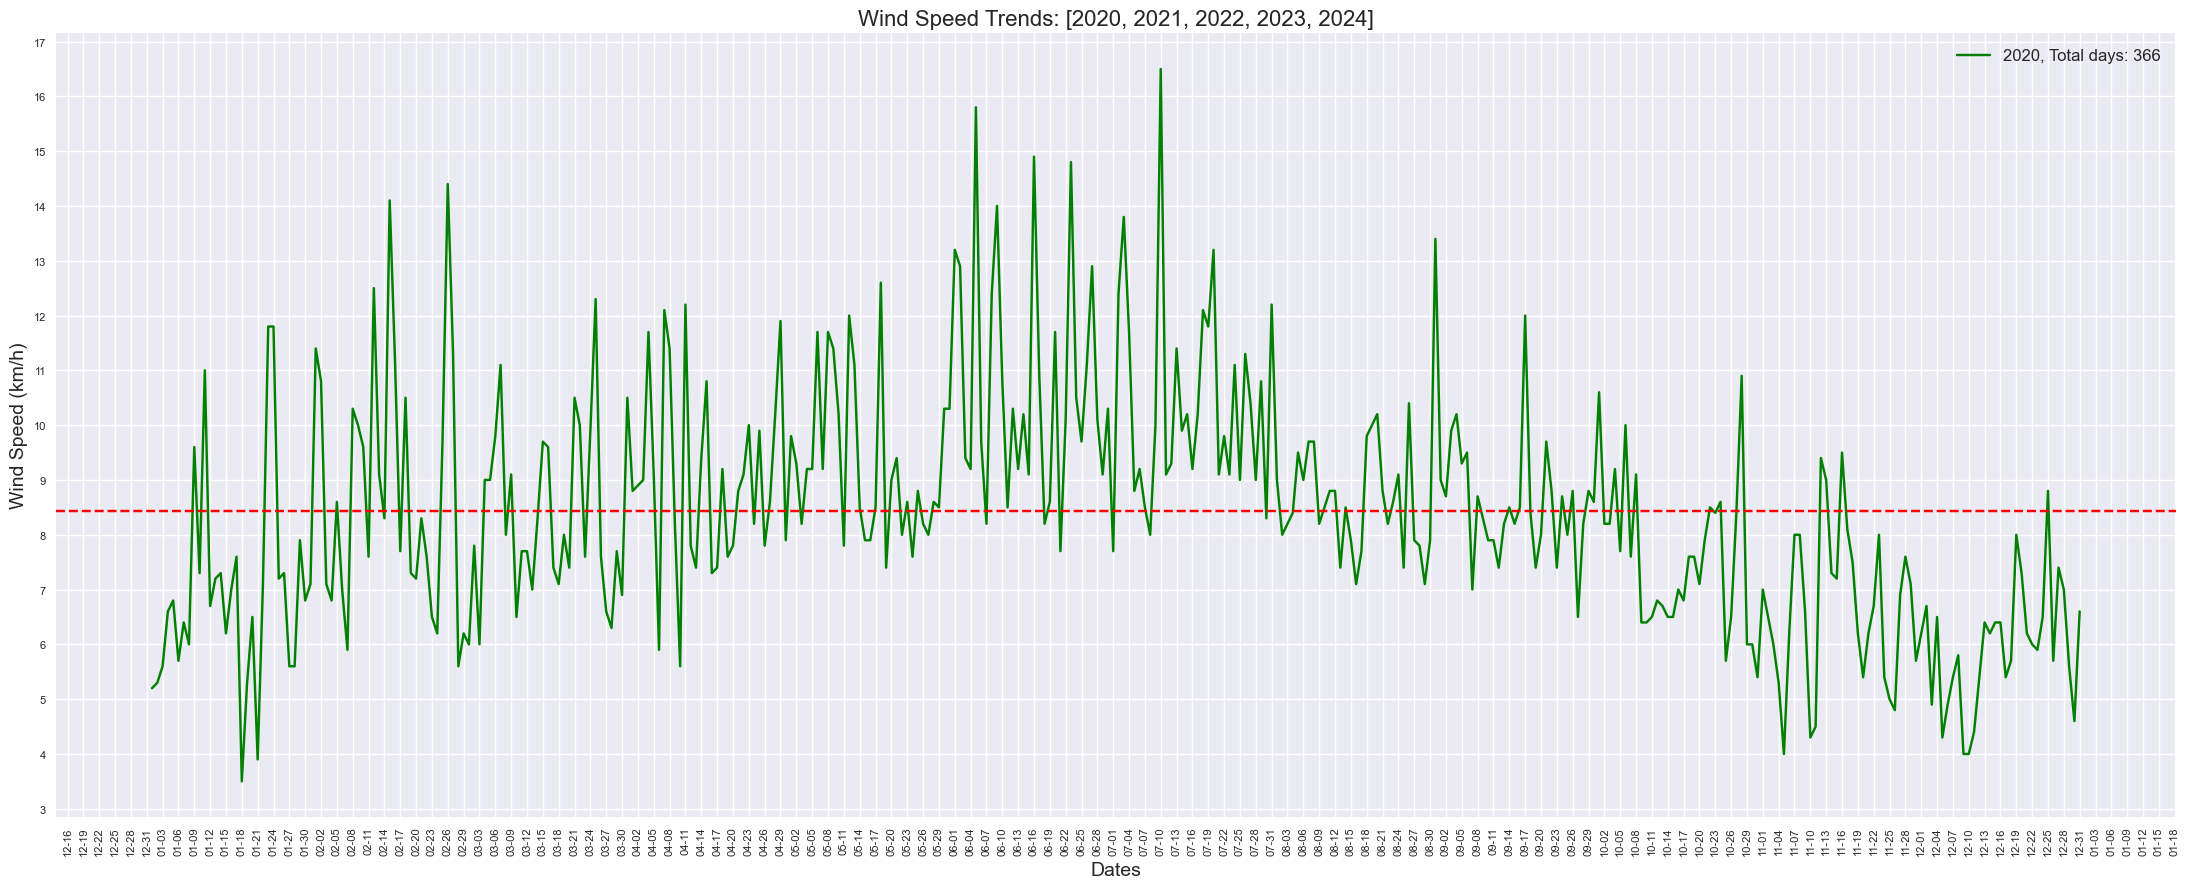

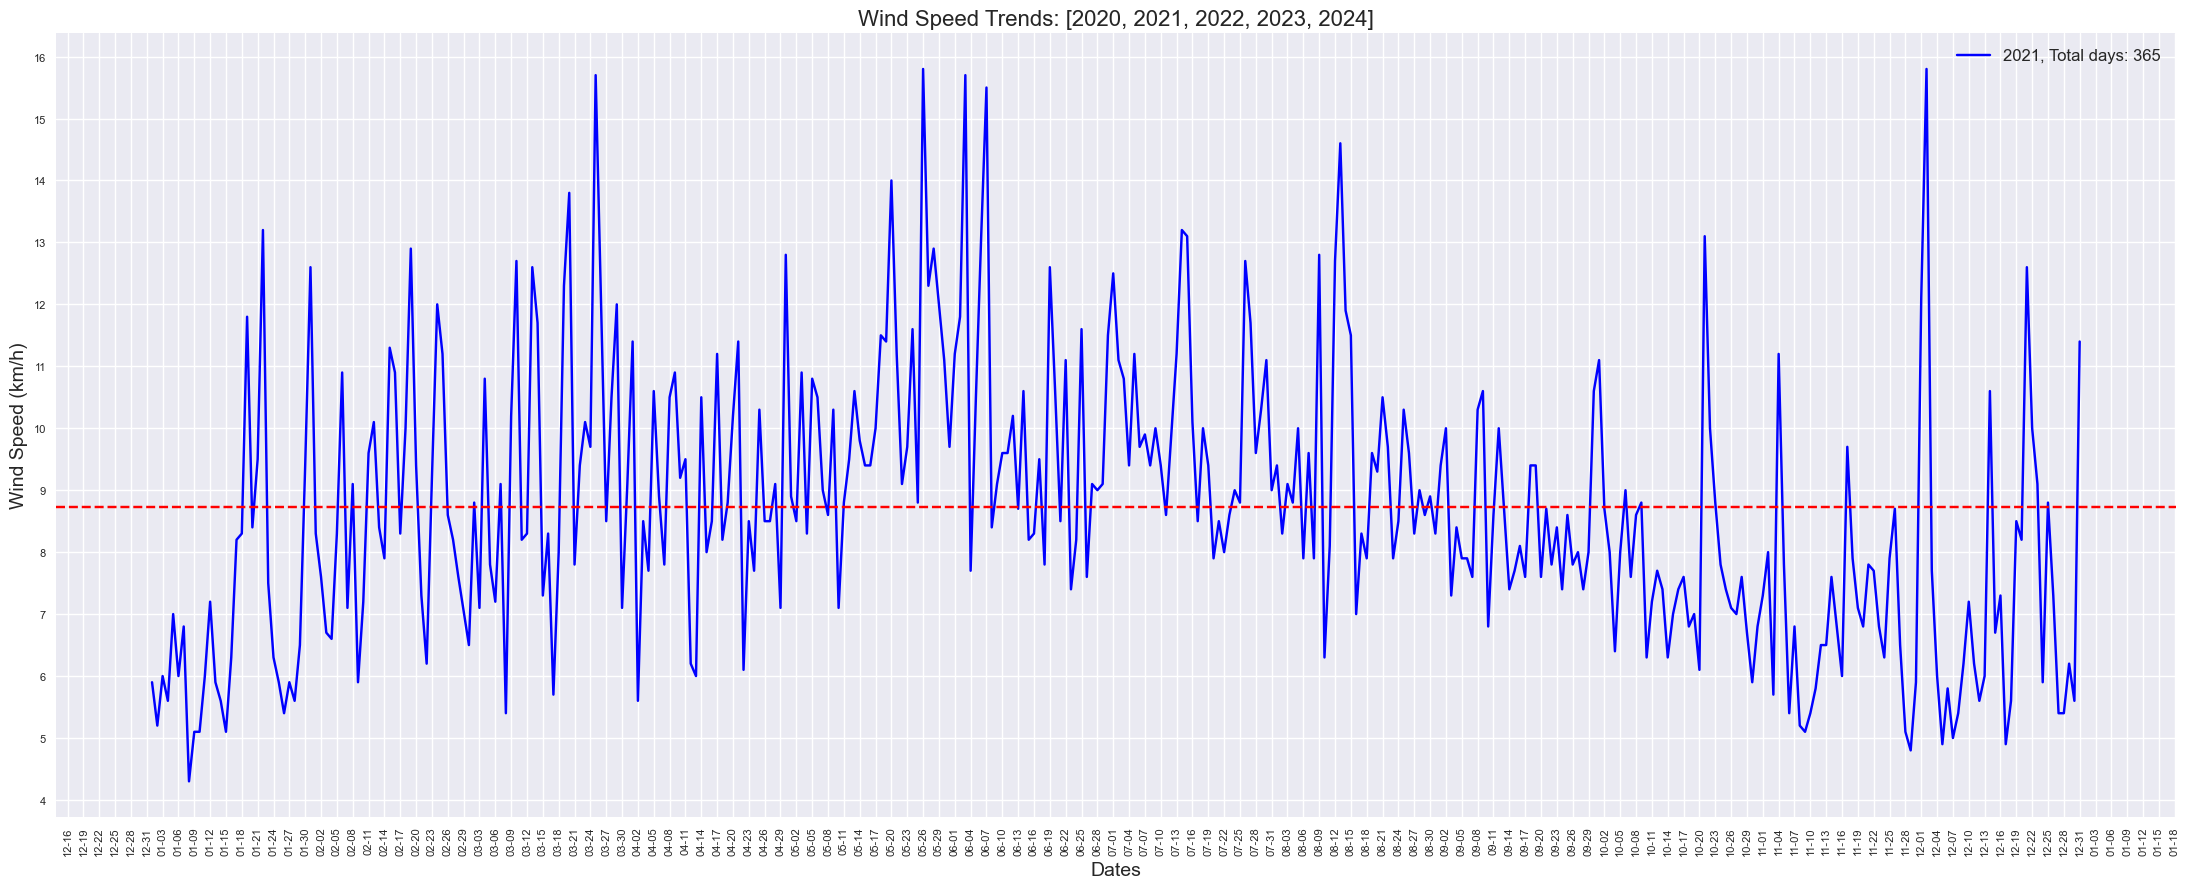

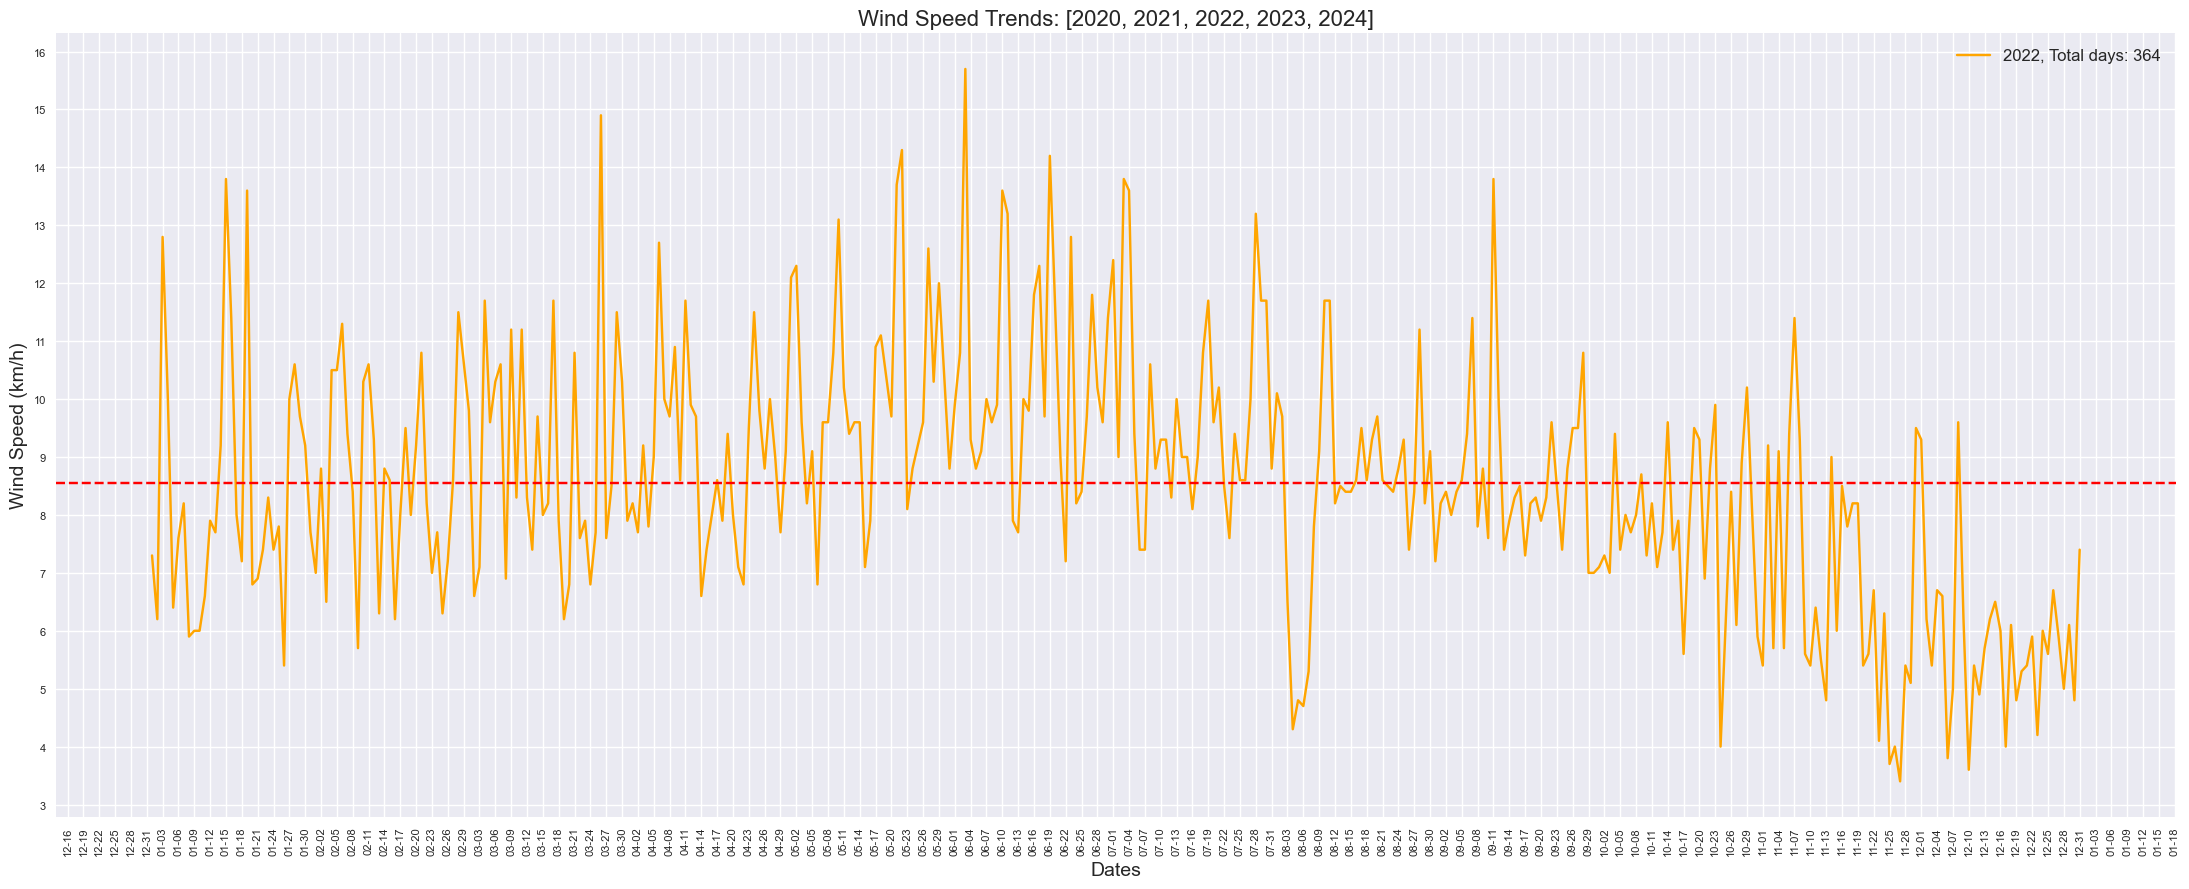

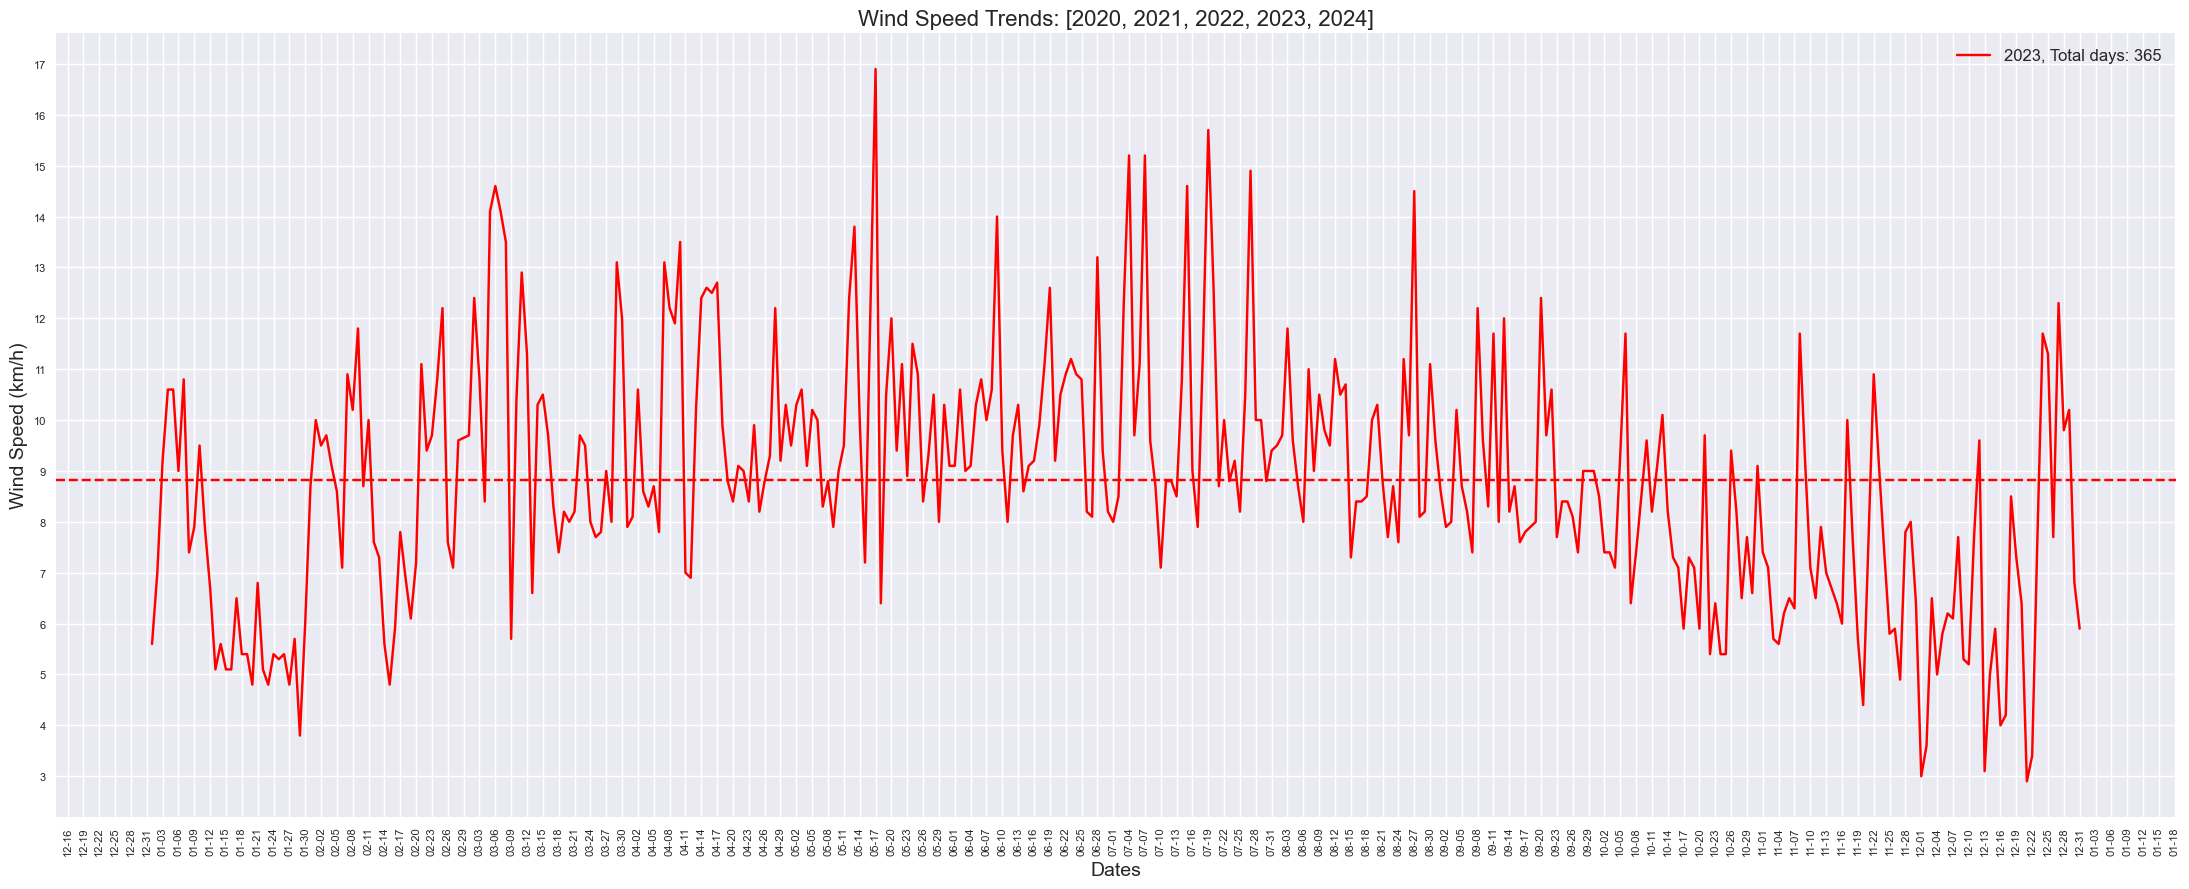

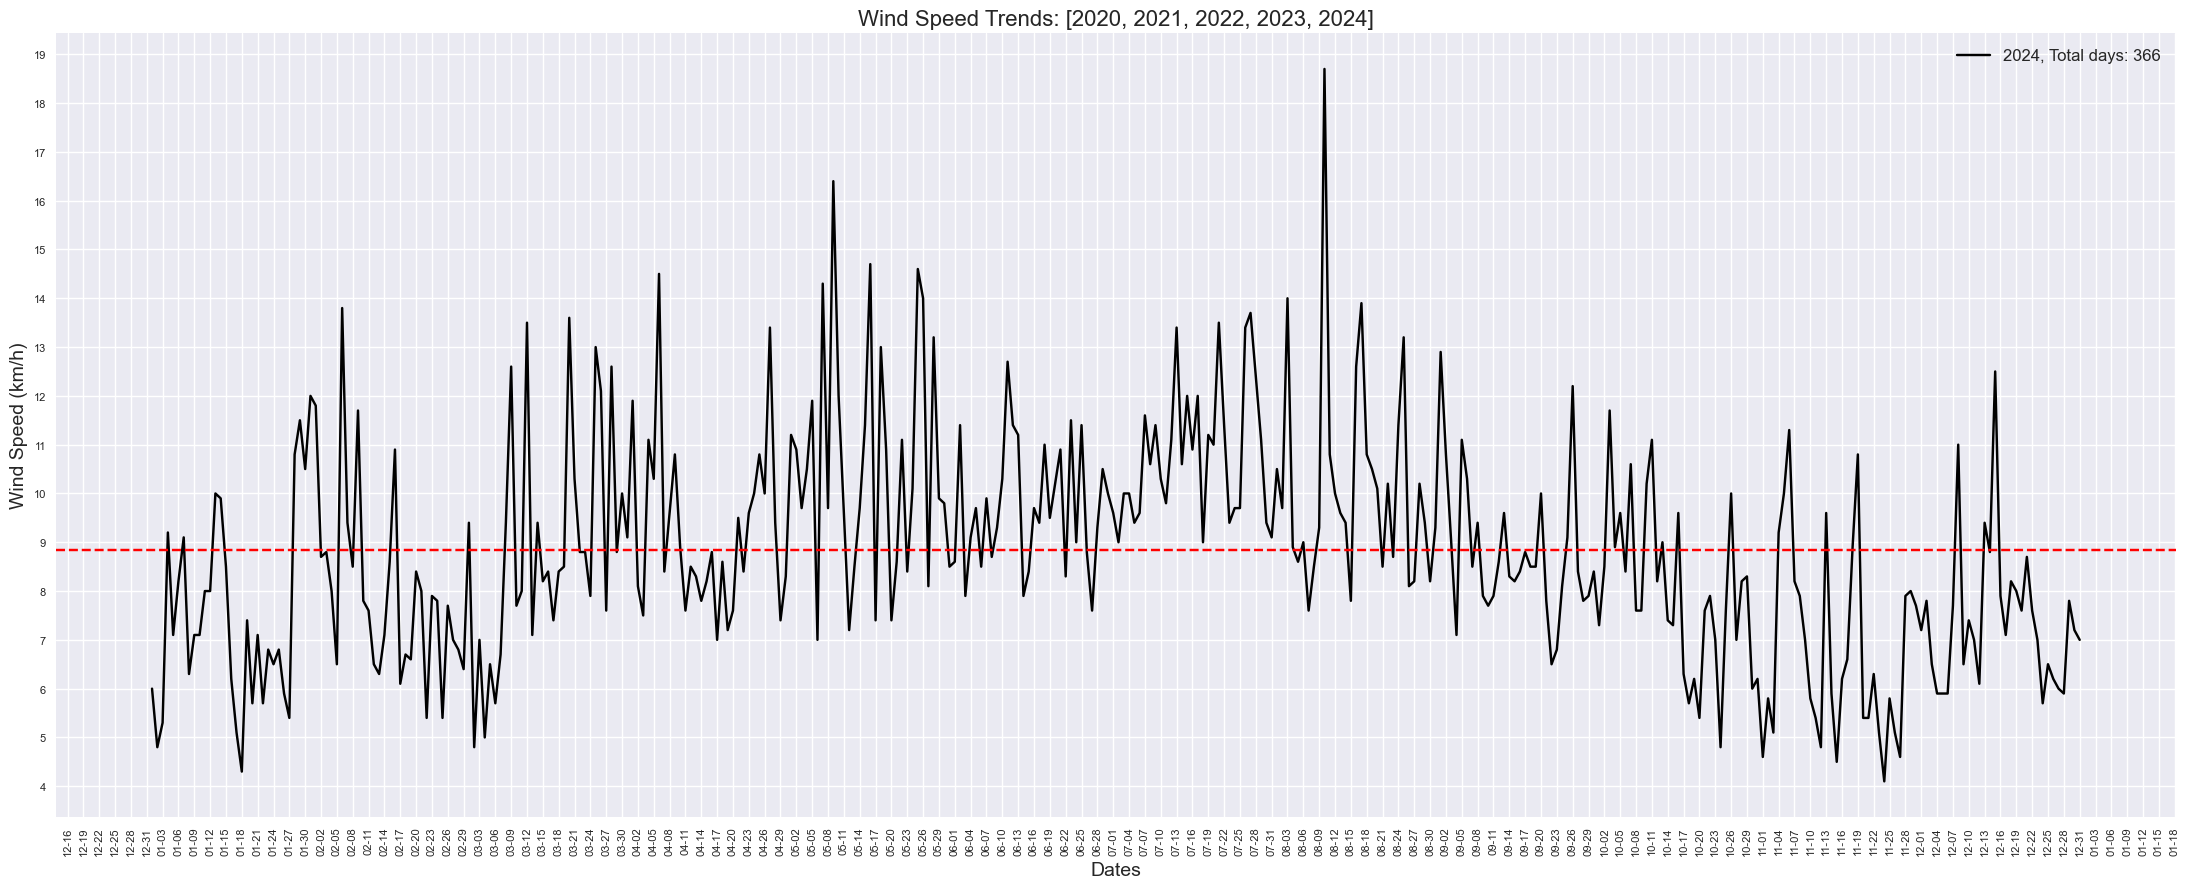

Analysis complete.


In [20]:
def analyze_wind_year(target_year):
    """
    Plots wind data for a specific year
    Example: analyze_wind_year(2022)
    """
    plt.style.use("seaborn-v0_8")

    colors = {2020: 'green', 2021: 'blue', 2022: 'orange', 2023: 'red', 2024: 'black'}
    available_data = df['real_year'].unique()

    for year in target_year:
        if year not in available_data:
            print(f"Year {year} not found in data. Skipping to the next year.")
            continue

        subset = df[df['real_year'] == year]

        fig, ax = plt.subplots(figsize=(22, 9))
        ax.plot(subset['plot_date'], subset['wspd'], 
               label=f"{year}, Total days: {len(subset)}",
               color=colors.get(year, 'gray')) # Gray if year not in color dict

        ax.set_title(f"Wind Speed Trends: {target_year}", fontsize = 16)
        ax.set_ylabel("Wind Speed (km/h)", fontsize = 14)
        ax.set_xlabel("Dates", fontsize = 14)
        ax.legend(loc = 'upper right', fontsize = 12)

        ax.axhline(y=subset['wspd'].mean(), color='red', linestyle='--', label='Average Wind Speed')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.xticks(rotation=90, size=8)
        plt.yticks(size=8)
        plt.tight_layout()
        plt.show()

    print("Analysis complete.")

analyze_wind_year([2020, 2021, 2022, 2023, 2024])

In [ ]:
""""""

All in One Canvas

Tool Loaded! Run the command below.


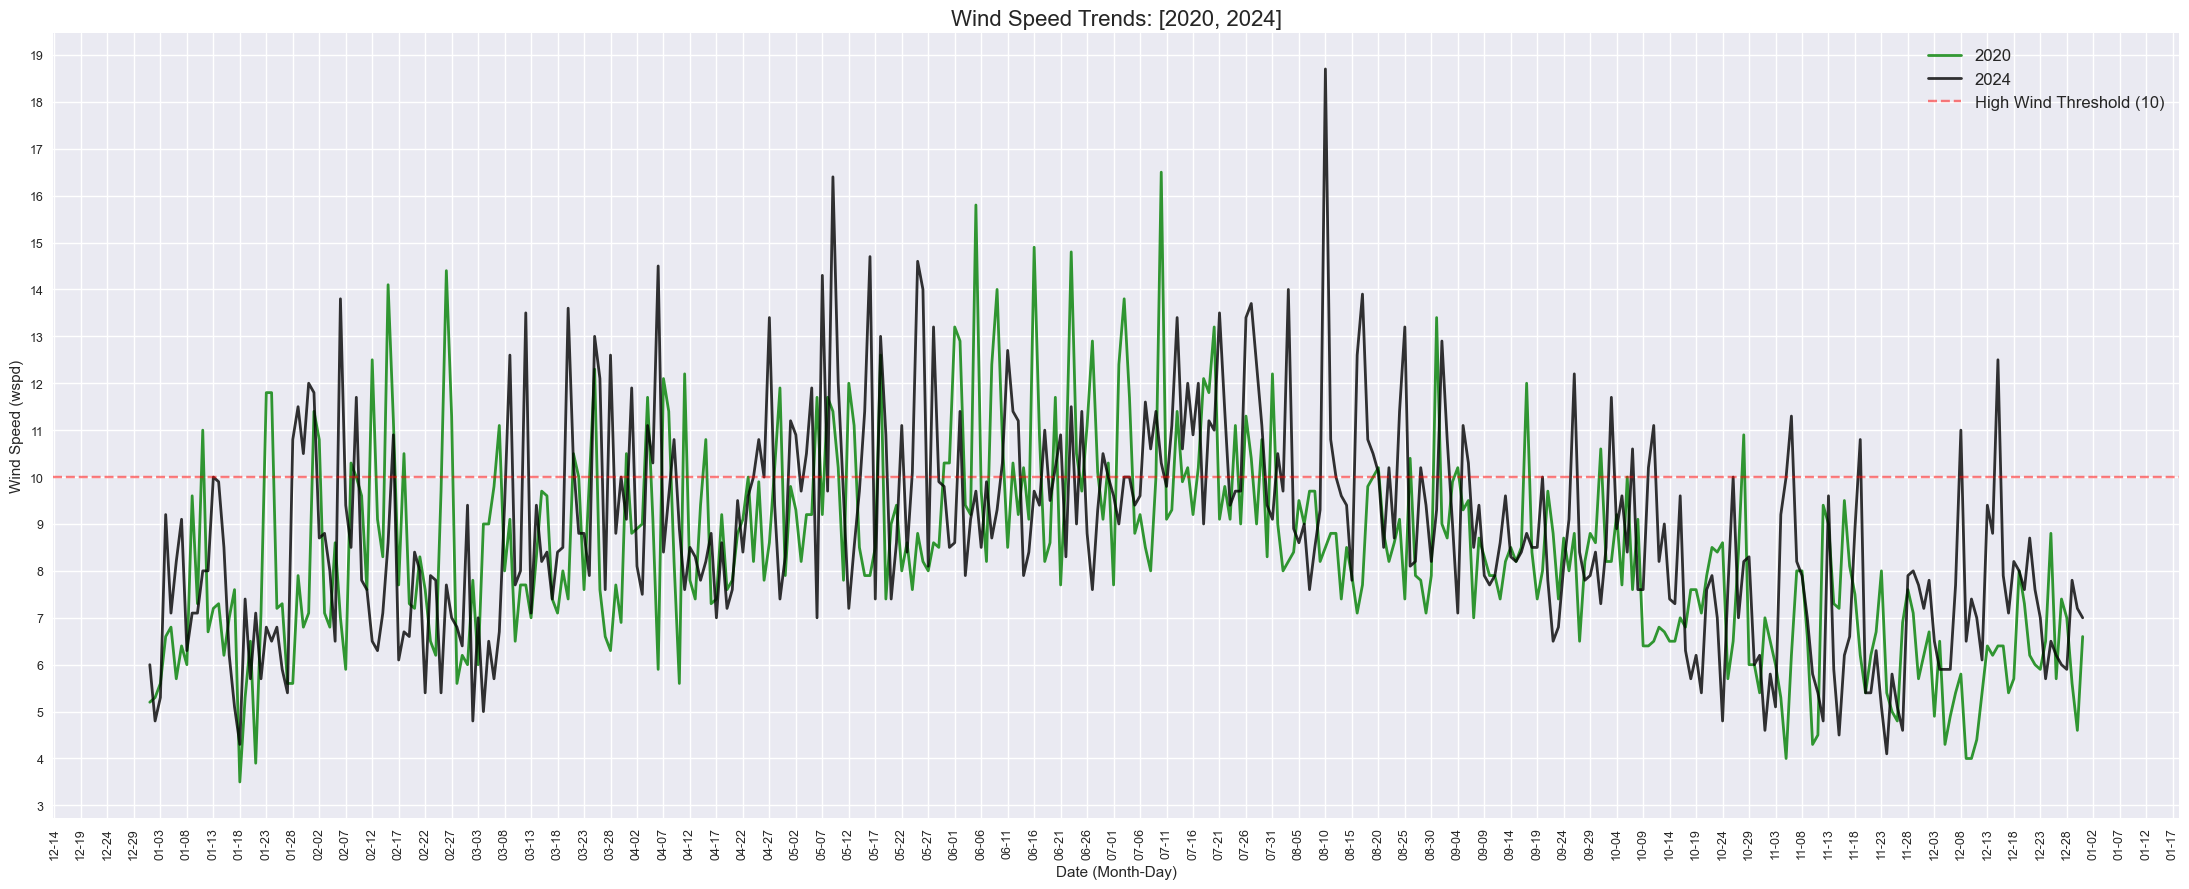

In [21]:
def analyze_wind_years(target_years):
    """
    Plots wind data for specific years provided in a list.
    Example: analyze_wind_years([2020, 2022])
    """
    
    # 1. Setup Canvas (Inside the function)
    plt.style.use("seaborn-v0_8")
    fig, ax = plt.subplots(figsize=(22, 9))

    # 2. Define Colors
    colors = {2020: 'green', 2021: 'blue', 2022: 'orange', 2023: 'red', 2024: 'black'}

    # 3. Validation: Make sure we only ask for years that exist
    available_data = df['real_year'].unique()
    
    # 4. The Loop
    for year in target_years:
        if year not in available_data:
            print(f"No data found for {year}. Skipping...")
            continue
            
        subset = df[df['real_year'] == year]
        
        ax.plot(subset['plot_date'], subset['wspd'], 
                label=f"{year}", 
                color=colors.get(year, 'gray'),
                linewidth=2, 
                alpha=0.8) # Made it slightly less transparent to see single years better

    ax.set_title(f"Wind Speed Trends: {target_years}", fontsize=16)
    ax.set_ylabel("Wind Speed (wspd)")
    ax.set_xlabel("Date (Month-Day)")

    # Threshold Line
    ax.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='High Wind Threshold (10)')

    # Axis Magic
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5)) # Every 5 days
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.xticks(rotation=90, size=9)
    plt.yticks(size=9)
    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

print("Tool Loaded! Run the command below.")


analyze_wind_years([2020, 2024])